In [12]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
base_dir = 'C:\\Projects\\ature'
import os
os.chdir(base_dir) #BASE DIRECTORY
import sys
import numpy as np
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import SegmentedImage
import cv2
import preprocess.utils.filter_utils as filutils
import preprocess.utils.img_utils as imgutils
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
### DRIVE dataset path setup #####
data_file_path = 'data\\DRIVE\\test\\images'
mask_path = 'data\\DRIVE\\test\\mask'
ground_truth_path = 'data\\DRIVE\\test\\1st_manual'

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'
def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

input_image = '19_test.tif'
###### Path end #####

########### PARAMS ##########
BILATERAL_KERNEL_SIZE = 41
BILATERAL_SIGMA_COLOR = 20
BILATERAL_SIGMA_SPACE = 20

kernels1 = filutils.build_filter_bank(k_size=31, gamma=0.7, lambd=5, sigma=2, orientations=64, psi=0)
kernels2 = filutils.build_filter_bank(k_size=31, gamma=0.7, lambd=8, sigma=3, orientations=64, psi=0)
kernels3 = filutils.build_filter_bank(k_size=31, gamma=0.7, lambd=11, sigma=4, orientations=64, psi=0)
kernels = kernels1 + kernels2 + kernels3

params = {'sk_threshold': 60,
          'alpha': 9.0,
          'orig_contrib': 0.7,
          'seg_threshold': 20}
##### Params end

In [14]:
img_obj = SegmentedImage()

img_obj.load_file(data_dir=data_file_path, file_name=input_image)
img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]

img_obj.apply_mask()
img_obj.apply_bilateral(k_size=BILATERAL_KERNEL_SIZE, sig_color=BILATERAL_SIGMA_COLOR, sig_space=BILATERAL_SIGMA_SPACE)
img_obj.apply_gabor(filter_bank=kernels)

img_obj.apply_bilateral(k_size=BILATERAL_KERNEL_SIZE, sig_color=BILATERAL_SIGMA_COLOR, sig_space=BILATERAL_SIGMA_SPACE)
img_obj.working_arr = img_obj.res['bilateral']

img_obj.generate_skeleton(threshold=params['sk_threshold'])
img_obj.generate_lattice_graph()

Mask loaded: 19_test_mask.gif
Ground truth loaded: 19_manual1.gif
"apply_bilateral(__)" ... took 0.218 seconds
"apply_gabor(__)" ... took 2.177 seconds
"apply_bilateral(__)" ... took 0.214 seconds
"generate_skeleton(__)" ... took 0.004 seconds
"generate_lattice_graph(__)" ... took 3.762 seconds


In [15]:
### Run for image files with in-time mask erosion
tester = AtureTest(out_dir='out')
tester.run(params=params, save_images=False, img_obj=img_obj)
img_obj.res['scores']

"run_segmentation(__)" ... took 178.966 seconds
Number of params combination tried: 1


{'Accuracy': 0.9758637410595223,
 'F1': 0.8502500846150953,
 'Precision': 0.875944364805703,
 'Recall': 0.8260202404004238}

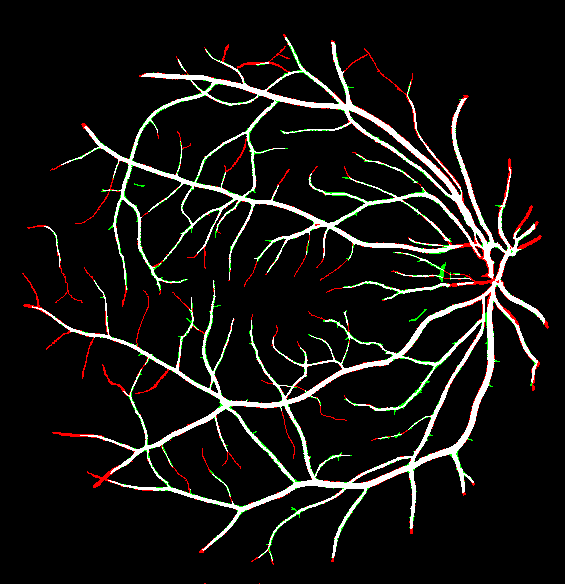

In [16]:
IMG.fromarray(img_obj.res['segmented_rgb'])

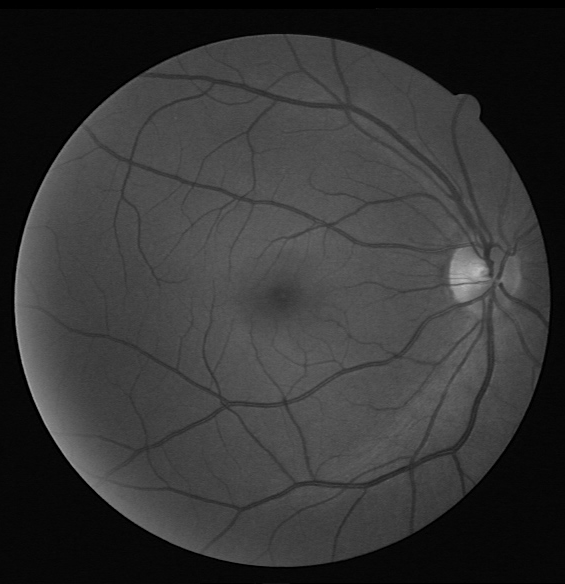

In [6]:
IMG.fromarray(img_obj.res['orig'])

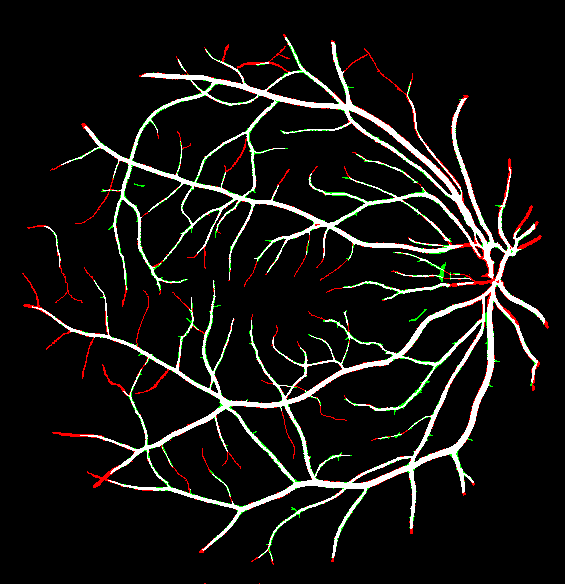

In [7]:
IMG.fromarray(img_obj.res['segmented_rgb'])

In [8]:
fni = np.full(img_obj.res['segmented'].shape, 250, dtype=np.uint8)
for i in range(fni.shape[0]):
    for j in range(fni.shape[1]):
        if img_obj.res['segmented'][i,j] == 0 and img_obj.ground_truth[i,j] == 255:
                       fni[i, j] = img_obj.working_arr[i, j]

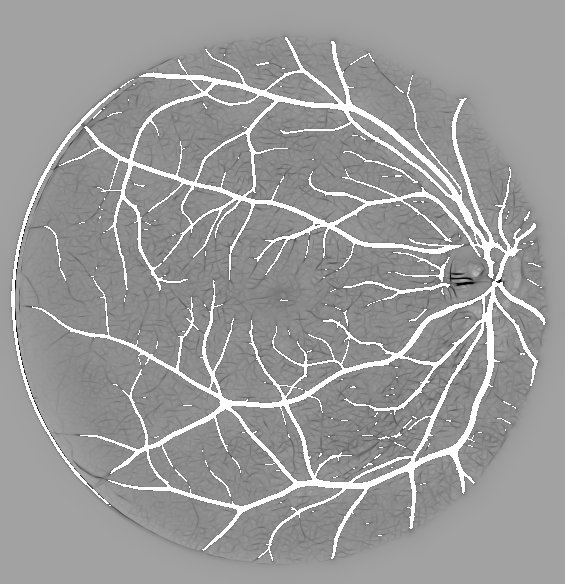

In [9]:
m = img_obj.working_arr.copy()
for n1, n2 in img_obj.res['graph'].edges():
    m[n1] = 255
    m[n2] = 255
IMG.fromarray(m)

In [10]:
io = SegmentedImage()
io.working_arr = np.array(m.copy(),dtype=np.uint8)
io.res['orig'] = io.working_arr
io.generate_lattice_graph()
io.ground_truth = img_obj.ground_truth
io.mask = img_obj.mask

"generate_lattice_graph(__)" ... took 2.288 seconds


In [11]:
io.generate_skeleton(threshold=125)
rgb = np.zeros([m.shape[0], m.shape[1], 3], dtype=np.uint8)
imgutils.rgb_scores(arr_2d=io.res['skeleton'], truth=io.ground_truth, arr_rgb=rgb)

"generate_skeleton(__)" ... took 0.0 seconds


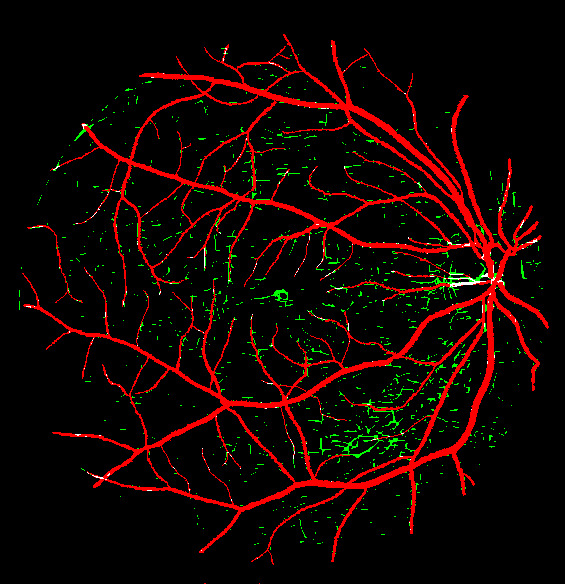

In [12]:
IMG.fromarray(rgb)

In [13]:
pms = {'sk_threshold': 60,
          'alpha': 9.0,
          'orig_contrib': 0.7,
          'seg_threshold': 40}
tester1 = AtureTest(out_dir='out')
acc = tester.run(params=pms, save_images=False, img_obj=io)

"run_segmentation(__)" ... took 65.605 seconds
Number of params combination tried: 2


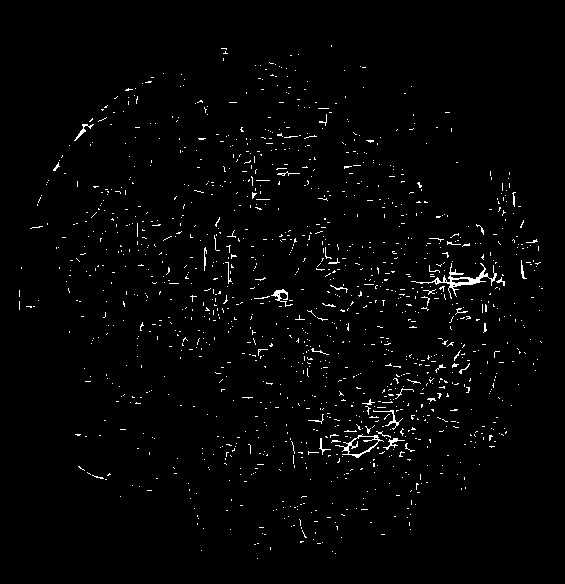

In [14]:
IMG.fromarray(io.res['segmented'])

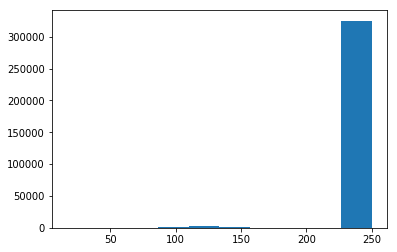

In [15]:
imgutils.histogram(fni, bins=10)

In [16]:
ig = SegmentedImage()

In [17]:
ig.working_arr = img_obj.working_arr[:,200:300]
ig.res['orig'] = img_obj.working_arr[:,200:300]
ig.ground_truth = img_obj.ground_truth[:,200:300]
ig.mask = img_obj.mask[:,200:300]
ig.generate_lattice_graph()
ig.generate_skeleton()

"generate_lattice_graph(__)" ... took 0.234 seconds
"generate_skeleton(__)" ... took 0.013 seconds


In [18]:
pms = {'sk_threshold': 60,
          'alpha': 9.0,
          'orig_contrib': 0.7,
          'seg_threshold': 20}
tester1 = AtureTest(out_dir='out')
tester1.run(params=pms, save_images=False, img_obj=ig)
ig.res['scores']

"run_segmentation(__)" ... took 6.177 seconds
Number of params combination tried: 1


{'Accuracy': 0.970736301369863,
 'F1': 0.8548126752187579,
 'Precision': 0.8975914362176628,
 'Recall': 0.8159260460590334}

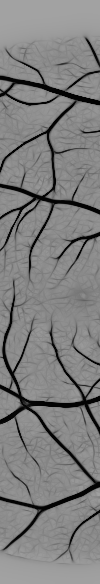

In [19]:
IMG.fromarray(ig.res['orig'])

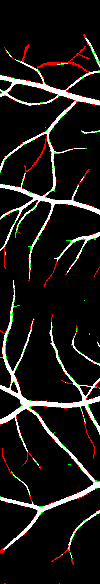

In [20]:
IMG.fromarray(ig.res['segmented_rgb'])

In [21]:
cost = []
for n1,n2 in io.res['graph'].edges():
    cost.append(io.res['graph'][n1][n2]['cost'])